In [1]:
# packages
import numpy as np #math operations
from scipy.sparse.linalg import eigsh #Lanczos diagonalization for hermitian matrices
import matplotlib.pyplot as plt #plots

# Canonical forms

$\quad$ Before going into the implementation of DMRG, we first build a function that transforms an arbitrary MPS into a convenient canonical form.

$\quad$ We start by creating a random MPS with $N$ sites, physical dimension $d$ (for simplicity, equal in all sites) and bond dimension $D$ (for simplicity, equal in all bonds, except for the outer bonds, which are set trivial), as depicted below.

<img src="MPS.svg" width=600 />

In [2]:
# parameters
N = 10
d = 3
D = 20

# random MPS
'''
    Order of legs: left-bottom-right. 
    Note: this is the conventional order used for MPSs in the code.
'''
Mrand = []
Mrand.append(np.random.rand(1,d,D))
for l in range(1,N-1):
    Mrand.append(np.random.rand(D,d,D))
Mrand.append(np.random.rand(D,d,1))

$\quad$ We now define a function that takes an MPS as input and transforms it into left canonical form, normalizing it. The output of this function is an equivalent description of the input MPS (apart from the normalization) where all tensors are left normalized. This is achieved using SVD, following the procedure depicted below.

<img src="LeftCanonical_procedure.svg" width=800 />

<u>Clarifying note</u>: the dashed line is a graphical notation to symbolize that the tensor is normalized with respect to those indices. For example, if a 3-leg tensor $U^{\alpha,\sigma,\beta}$ has a dashed line between legs $\alpha$ and $\sigma$, we have
$$
\sum_{\alpha,\sigma} \left( U^{\alpha,\sigma,\beta} \right)^* U^{\alpha,\sigma,\beta'} = \delta_{\beta,\beta'}, 
$$
or, in matrix notation,
$$
U^\dagger U = I,
$$
where the basis $\{ (\alpha,\sigma),\beta \}$ is implicit.

In [3]:
'''
    Function that takes an MPS 'M' as input (order of legs: left-bottom-right) and returns a copy of it that is
        transformed into left canonical form and normalized.
'''
def LeftCanonical(M):
    Mcopy = M.copy() #create copy of M
    
    N = len(Mcopy) #nr of sites
    
    for l in range(N):
        # reshape
        Taux = Mcopy[l]
        Taux = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1],np.shape(Taux)[2]))
        
        # SVD
        U,S,Vdag = np.linalg.svd(Taux,full_matrices=False)
        '''
            Note: full_matrices=False leads to a trivial truncation of the matrices (thin SVD).
        '''
        
        # update M[l]
        Mcopy[l] = np.reshape(U,(np.shape(Mcopy[l])[0],np.shape(Mcopy[l])[1],np.shape(U)[1]))
        
        # update M[l+1]
        SVdag = np.matmul(np.diag(S),Vdag)
        if l < N-1:         
            Mcopy[l+1] = np.einsum('ij,jkl',SVdag,Mcopy[l+1])
        else:
            '''
                Note: in the last site (l=N-1), S*Vdag is a number that determines the normalization of the MPS. 
                    We discard this number, which corresponds to normalizing the MPS.
            '''
            
    return Mcopy

$\quad$ Let us now test the use of the previous function. For that matter, we will check if, after applying it, all tensors become left normalized, i.e.,

<img src="left_normalization.svg" width=300 />

In [4]:
Mleft = LeftCanonical(Mrand)
for l in range(N):
    Mdag = Mleft[l].conj().T #right-top-left
    '''
        Note: as a consequence of the conventional leg order chosen for the MPSs, the corresponding hermitian
            conjugate versions are ordered as right-top-left.
    ''' 
    MdagM = np.einsum('ijk,kjl',Mdag,Mleft[l]) #bottom-top
    I = np.eye(np.shape(Mleft[l])[2]) #(leg order is indiferent)
    print('l =', l, ': max(|M[l]^† · M[l] - I|) =', np.max(abs(MdagM-I)))

l = 0 : max(|M[l]^† · M[l] - I|) = 8.881784197001252e-16
l = 1 : max(|M[l]^† · M[l] - I|) = 1.1102230246251565e-15
l = 2 : max(|M[l]^† · M[l] - I|) = 1.6653345369377348e-15
l = 3 : max(|M[l]^† · M[l] - I|) = 3.552713678800501e-15
l = 4 : max(|M[l]^† · M[l] - I|) = 1.5543122344752192e-15
l = 5 : max(|M[l]^† · M[l] - I|) = 1.5543122344752192e-15
l = 6 : max(|M[l]^† · M[l] - I|) = 1.5543122344752192e-15
l = 7 : max(|M[l]^† · M[l] - I|) = 1.7763568394002505e-15
l = 8 : max(|M[l]^† · M[l] - I|) = 1.3322676295501878e-15
l = 9 : max(|M[l]^† · M[l] - I|) = 2.220446049250313e-16


$\quad$ Analogously, we define and test a function that takes an MPS as input and brings it into right canonical form, normalizing it.

In [5]:
'''
    Function that takes an MPS 'M' as input (order of legs: left-bottom-right) and returns a copy of it that is
        transformed into right canonical form and normalized.
'''
def RightCanonical(M):
    Mcopy = M.copy() #create copy of M
    
    N = len(Mcopy) #nr of sites
    
    for l in range(N-1,-1,-1):
        # reshape
        Taux = Mcopy[l]
        Taux = np.reshape(Taux,(np.shape(Taux)[0],np.shape(Taux)[1]*np.shape(Taux)[2]))
        
        # SVD
        U,S,Vdag = np.linalg.svd(Taux,full_matrices=False)
        
        # update M[l]
        Mcopy[l] = np.reshape(Vdag,(np.shape(Vdag)[0],np.shape(Mcopy[l])[1],np.shape(Mcopy[l])[2]))
        
        # update M[l-1]
        US = np.matmul(U,np.diag(S))
        if l > 0:         
            Mcopy[l-1] = np.einsum('ijk,kl',Mcopy[l-1],US)
        else:
            '''
                Note: in the first site (l=0), U*S is a number that determines the normalization of the MPS. We 
                    discard this number, which corresponds to normalizing the MPS.
            '''
            
    return Mcopy

In [6]:
Mright = RightCanonical(Mrand)
for l in range(N):
    Mdag = Mright[l].conj().T #right-top-left
    MMdag = np.einsum('ijk,kjl',Mright[l],Mdag) #top-bottom
    I = np.eye(np.shape(Mright[l])[0]) #(leg order is indiferent)
    print('l =', l, ': max(|M[l] · M[l]^† - I|) =', np.max(abs(MMdag-I)))

l = 0 : max(|M[l] · M[l]^† - I|) = 2.220446049250313e-16
l = 1 : max(|M[l] · M[l]^† - I|) = 1.5543122344752192e-15
l = 2 : max(|M[l] · M[l]^† - I|) = 2.220446049250313e-15
l = 3 : max(|M[l] · M[l]^† - I|) = 1.1102230246251565e-15
l = 4 : max(|M[l] · M[l]^† - I|) = 8.881784197001252e-16
l = 5 : max(|M[l] · M[l]^† - I|) = 1.5543122344752192e-15
l = 6 : max(|M[l] · M[l]^† - I|) = 1.5543122344752192e-15
l = 7 : max(|M[l] · M[l]^† - I|) = 1.7763568394002505e-15
l = 8 : max(|M[l] · M[l]^† - I|) = 1.4432899320127035e-15
l = 9 : max(|M[l] · M[l]^† - I|) = 4.440892098500626e-16


$\quad$ As a final remark, we note that in tensor network algorithms starting with a random MPS with trivial outer bonds, it is standard practice to apply both 'LeftCanonical' and 'RightCanonical' functions once. This ensures two things: i) that the random MPS is normalized; ii) that some (redundant) bond dimensions (typically closer to the end sites) are trivially truncated due to the thin SVD.

In [7]:
print('Dimensions of Mrand:')
for l in range(N):
    print('l =', l, ':', np.shape(Mrand[l]))

Mrand2 = LeftCanonical(Mrand)
print("\nAfter LeftCanonical function:")
for l in range(N):
    print('l =', l, ':', np.shape(Mrand2[l]))
    
Mrand3 = RightCanonical(Mrand2)
print("\nAfter LeftCanonical and RightCanonical functions:")
for l in range(N):
    print('l =', l, ':', np.shape(Mrand3[l]))

Dimensions of Mrand:
l = 0 : (1, 3, 20)
l = 1 : (20, 3, 20)
l = 2 : (20, 3, 20)
l = 3 : (20, 3, 20)
l = 4 : (20, 3, 20)
l = 5 : (20, 3, 20)
l = 6 : (20, 3, 20)
l = 7 : (20, 3, 20)
l = 8 : (20, 3, 20)
l = 9 : (20, 3, 1)

After LeftCanonical function:
l = 0 : (1, 3, 3)
l = 1 : (3, 3, 9)
l = 2 : (9, 3, 20)
l = 3 : (20, 3, 20)
l = 4 : (20, 3, 20)
l = 5 : (20, 3, 20)
l = 6 : (20, 3, 20)
l = 7 : (20, 3, 20)
l = 8 : (20, 3, 20)
l = 9 : (20, 3, 1)

After LeftCanonical and RightCanonical functions:
l = 0 : (1, 3, 3)
l = 1 : (3, 3, 9)
l = 2 : (9, 3, 20)
l = 3 : (20, 3, 20)
l = 4 : (20, 3, 20)
l = 5 : (20, 3, 20)
l = 6 : (20, 3, 20)
l = 7 : (20, 3, 9)
l = 8 : (9, 3, 3)
l = 9 : (3, 3, 1)


# MPOs of Hamiltonians

$\quad$ In this section, we show how to build the MPO of a model Hamiltonian, following the strategy explained in the manuscript. For concreteness, we focus on Hamiltonians of 1D spin chains with open boundary conditions. A general representation of such an Hamiltonian MPO is depicted below, where $N$ is the number of sites in the chain and $d$ is the corresponding local dimension ($d=2s+1$ for a spin-$s$ system).

<img src="MPO_Hamiltonian.svg" width=600 />

For clarity purposes, we consider three different examples, which should illustrate how to do it for a general model.

## i) XY model

$\quad$ The Hamiltonian of an XY open-ended chain is given by
$$
\hat{\mathcal{H}}_\text{XY} = -\sum_{l=0}^{N-2} \left( \hat{\sigma}^x_l \hat{\sigma}^x_{l+1} + \hat{\sigma}^y_l \hat{\sigma}^y_{l+1} \right),
$$
where $N$ is the number of $s=1/2$ spins and $\hat{\sigma}^{x/y}_l$ are the $x$/$y$ spin-1/2 operators at site $l$.

$\quad$ Straightforward manipulation gives
$$
\hat{\mathcal{H}}_\text{XY} = -\frac{1}{2} \sum_{l=0}^{N-2} \left( \hat{\sigma}^+_l \hat{\sigma}^-_{l+1} + \hat{\sigma}^-_l \hat{\sigma}^+_{l+1} \right),
$$
where $\hat{\sigma}^\pm_l = \hat{\sigma}^x_l \pm \mathrm{i} \hat{\sigma}^y_l$ are the spin ladder operators.

In [8]:
'''
    Function that creates the MPO Hamiltonian (order of legs: left-bottom-right-top) for an XY chain with N 
        (s=1/2) spins and open boundary conditions.
'''
def XY_MPO(N):
    # spin-1/2 operators
    '''
        Order of legs: bottom-top.
        Note: this is the conventional order used for (rank-2) local operators in the code.
    '''
    ## σ^+_l
    sp = np.zeros((2,2))
    sp[0,1] = 1
    ## σ^-_l
    sm = np.zeros((2,2))
    sm[1,0] = 1
    ## I_l
    I2 = np.eye(2)
    
    # MPO Hamiltonian
    '''
        Order of legs: left-bottom-right-top.
        Note: this is the conventional order used for MPOs in the code.
    '''
    ## H[l]
    Hl = np.zeros((4,2,4,2))
    Hl[0,:,0,:] = I2
    Hl[1,:,0,:] = sm
    Hl[2,:,0,:] = sp
    Hl[3,:,1,:] = -0.5*sp
    Hl[3,:,2,:] = -0.5*sm
    Hl[3,:,3,:] = I2
    ## H
    H = [Hl for l in range(N)]
    H[0] = Hl[-1:np.shape(Hl)[0],:,:,:]
    H[N-1] = Hl[:,:,0:1,:]
    
    return H

$\quad$ For completeness, let us now show how to contract the Hamiltonian MPO to obtain the Hamiltonian matrix (in the physical basis), which can then be compared to that obtained by brute-force means. It must be noted that this procedure is not desired (and never done) in a tensor network algorithm, as the dimension of the Hamiltonian matrix scales exponentially with $N$, so that it can only be obtained for small $N$ (this remark is actually illustrative of how efficient MPOs are in the task of enconding the information of a model Hamiltonian). Here, we only do it to convince ourselves that the Hamiltonian MPO was properly constructed.

In [9]:
'''
    Function that creates the Hamiltonian matrix for an XY chain with N (s=1/2) spins and open boundary 
        conditions.
'''
def Hmat_XY(N):
    # spin-1/2 operators
    ## σ^+_l
    sp = np.zeros((2,2))
    sp[0,1] = 1
    ## σ^-_l
    sm = np.zeros((2,2))
    sm[1,0] = 1
    ## I_l
    I2 = np.eye(2)
    
    # Hamiltonian matrix
    H = np.zeros((2**N,2**N))
    for l in range(N-1):
        Ileft = np.eye(2**l) #I_0 x I_1 x ... I_{l-1}
        Hmid = -0.5*np.kron(sp,sm) #-1/2 * σ^+_l x σ^-_{l+1}
        Hmid += -0.5*np.kron(sm,sp) #-1/2 * σ^-_l x σ^+_{l+1}
        Iright = np.eye(2**(N-l-2)) #I_{l+2} x I_{l+3} x ... I_{N-1}
        H += np.kron(np.kron(Ileft,Hmid),Iright)
    
    return H

In [10]:
# parameters
N = 5

# Hamiltonian matrix from MPO
H_MPO = XY_MPO(N)
for l in range(N):
    if l==0:
        Taux = H_MPO[l][0,:,:,:]
    else:
        Taux = np.einsum('ijk,jlmn',Taux,H_MPO[l])
        Taux = np.transpose(Taux,(0,2,3,1,4))
        Taux = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1],np.shape(Taux)[2],
                                np.shape(Taux)[3]*np.shape(Taux)[4]))
Hmat = Taux[:,0,:]

# brute-force Hamiltonian matrix
Hmat2 = Hmat_XY(N)

# difference
print('difference between MPO and brute-force Hamiltonians =', np.max(abs(Hmat-Hmat2)))

difference between MPO and brute-force Hamiltonians = 0.0


## ii) Majumdar-Ghosh model

$\quad$ The Majumdar-Ghosh model (https://doi.org/10.1063/1.1664979) describes a chain of $N$ $s=1/2$ spins, governed by the following Hamiltonian (assuming open boundary conditions):
$$
\hat{\mathcal{H}}_\text{MG} = \sum_{l=0}^{N-2} \hat{\vec{\sigma}}_l \cdot \hat{\vec{\sigma}}_{l+1} + \frac{1}{2} \sum_{l=0}^{N-3} \hat{\vec{\sigma}}_l \cdot \hat{\vec{\sigma}}_{l+2},
$$
where $\hat{\vec{\sigma}}_l = (\hat{\sigma}^x_l, \hat{\sigma}^y_l, \hat{\sigma}^z_l)$ is the vector of spin-1/2 operators at site $l$.

$\quad$ Straightforward manipulation yields
$$
\hat{\mathcal{H}}_\text{MG} = \sum_{l=0}^{N-2} \left( \hat{\sigma}^z_l \hat{\sigma}^z_{l+1} + \frac{1}{2} \hat{\sigma}^+_l \hat{\sigma}^-_{l+1} + \frac{1}{2} \hat{\sigma}^-_l \hat{\sigma}^+_{l+1} \right) + \sum_{l=0}^{N-3} \left( \frac{1}{2} \hat{\sigma}^z_l \hat{\sigma}^z_{l+2} + \frac{1}{4} \hat{\sigma}^+_l \hat{\sigma}^-_{l+2} + \frac{1}{4} \hat{\sigma}^-_l \hat{\sigma}^+_{l+2} \right).
$$

In [11]:
'''
    Function that creates the MPO Hamiltonian (order of legs: left-bottom-right-top) for a Majumdar-Ghosh chain 
        with N (s=1/2) spins and open boundary conditions.
'''
def MG_MPO(N):
    # spin-1/2 operators (bottom-top)
    ## σ^z_l
    sz = np.zeros((2,2))
    sz[0,0] = 1/2
    sz[1,1] = -1/2
    ## σ^+_l
    sp = np.zeros((2,2))
    sp[0,1] = 1
    ## σ^-_l
    sm = np.zeros((2,2))
    sm[1,0] = 1
    ## I_l
    I2 = np.eye(2)
    
    # MPO Hamiltonian (left-bottom-right-top)
    ## H[l]
    Hl = np.zeros((8,2,8,2))
    Hl[0,:,0,:] = I2
    Hl[1,:,0,:] = sz
    Hl[2,:,0,:] = sm
    Hl[3,:,0,:] = sp
    Hl[4,:,1,:] = I2
    Hl[5,:,2,:] = I2
    Hl[6,:,3,:] = I2
    Hl[7,:,1,:] = sz
    Hl[7,:,2,:] = 0.5*sp
    Hl[7,:,3,:] = 0.5*sm
    Hl[7,:,4,:] = 0.5*sz
    Hl[7,:,5,:] = 1/4*sp
    Hl[7,:,6,:] = 1/4*sm
    Hl[7,:,7,:] = I2
    ## H
    H = [Hl for l in range(N)]
    H[0] = Hl[-1:np.shape(Hl)[0],:,:,:]
    H[N-1] = Hl[:,:,0:1,:]
    
    return H

$\quad$ As a sanity check, we compare again with the brute-force Hamiltonian.

In [12]:
'''
    Function that creates the Hamiltonian matrix for a Majumdar-Ghosh chain with N (s=1/2) spins and open boundary 
        conditions.
'''
def Hmat_MG(N):
    # spin-1/2 operators
    ## σ^z_l
    sz = np.zeros((2,2))
    sz[0,0] = 1/2
    sz[1,1] = -1/2
    ## σ^+_l
    sp = np.zeros((2,2))
    sp[0,1] = 1
    ## σ^-_l
    sm = np.zeros((2,2))
    sm[1,0] = 1
    ## I_l
    I2 = np.eye(2)
    
    # Hamiltonian matrix
    H = np.zeros((2**N,2**N))
    for l in range(N-1):
        Ileft = np.eye(2**l) #I_0 x I_1 x ... I_{l-1}
        Hmid = np.kron(sz,sz) #σ^z_l x σ^z_{l+1}
        Hmid += 0.5*np.kron(sp,sm) #1/2 * σ^+_l x σ^-_{l+1}
        Hmid += 0.5*np.kron(sm,sp) #1/2 * σ^-_l x σ^+_{l+1}
        Iright = np.eye(2**(N-l-2)) #I_{l+2} x I_{l+3} x ... I_{N-1}
        H += np.kron(np.kron(Ileft,Hmid),Iright)
    for l in range(N-2):
        Ileft = np.eye(2**l) #I_0 x I_1 x ... I_{l-1}
        Hmid = 0.5*np.kron(np.kron(sz,I2),sz) #1/2 * σ^z_l x I_{l+1} x σ^z_{l+2}
        Hmid += 1/4*np.kron(np.kron(sp,I2),sm) #1/4 * σ^+_l x I_{l+1} x σ^-_{l+2}
        Hmid += 1/4*np.kron(np.kron(sm,I2),sp) #1/4 * σ^-_l x I_{l+1} x σ^+_{l+2}
        Iright = np.eye(2**(N-l-3)) #I_{l+3} x I_{l+3} x ... I_{N-1}
        H += np.kron(np.kron(Ileft,Hmid),Iright)
    
    return H

In [13]:
# parameters
N = 5

# Hamiltonian matrix from MPO
H_MPO = MG_MPO(N)
for l in range(N):
    if l==0:
        Taux = H_MPO[l][0,:,:,:]
    else:
        Taux = np.einsum('ijk,jlmn',Taux,H_MPO[l])
        Taux = np.transpose(Taux,(0,2,3,1,4))
        Taux = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1],np.shape(Taux)[2],
                                np.shape(Taux)[3]*np.shape(Taux)[4]))
Hmat = Taux[:,0,:]

# brute-force Hamiltonian matrix
Hmat2 = Hmat_MG(N)

# difference
print('difference between MPO and brute-force Hamiltonians =', np.max(abs(Hmat-Hmat2)))

difference between MPO and brute-force Hamiltonians = 0.0


## iii) AKLT model
 
$\quad$ The AKLT model (https://doi.org/10.1103/PhysRevLett.59.799) describes a chain of $N$ $s=1$ spins, governed by the following Hamiltonian (assuming open boundary conditions):
$$
\hat{\mathcal{H}}_\text{AKLT} = \sum_{l=0}^{N-2} \left[ \hat{\vec{S}}_l \cdot \hat{\vec{S}}_{l+1} + \frac{1}{3} \left( \hat{\vec{S}}_l \cdot \hat{\vec{S}}_{l+1} \right)^2 \right],
$$
where $\hat{\vec{S}}_l = (\hat{S}^x_l, \hat{S}^y_l, \hat{S}^z_l)$ is the vector of spin-1 operators at site $l$. 

$\quad$ Straightforward manipulation leads to
$$
\hat{\mathcal{H}}_\text{AKLT} = \sum_{l=0}^{N-2} \left[ \hat{S}^z_l \hat{S}^z_{l+1} + \frac{1}{2} \hat{S}^+_l \hat{S}^-_{l+1} + \frac{1}{2} \hat{S}^-_l \hat{S}^+_{l+1} + \frac{1}{3} \hat{S}^z_l \hat{S}^z_l \hat{S}^z_{l+1} \hat{S}^z_{l+1} + \frac{1}{6} \hat{S}^z_l \hat{S}^+_l \hat{S}^z_{l+1} \hat{S}^-_{l+1} + \frac{1}{6} \hat{S}^z_l \hat{S}^-_l \hat{S}^z_{l+1} \hat{S}^+_{l+1} + \frac{1}{6} \hat{S}^+_l \hat{S}^z_l \hat{S}^-_{l+1} \hat{S}^z_{l+1} + \frac{1}{12} \hat{S}^+_l \hat{S}^+_l \hat{S}^-_{l+1} \hat{S}^-_{l+1} + \frac{1}{12} \hat{S}^+_l \hat{S}^-_l \hat{S}^-_{l+1} \hat{S}^+_{l+1} + \frac{1}{6} \hat{S}^-_l \hat{S}^z_l \hat{S}^+_{l+1} \hat{S}^z_{l+1} + \frac{1}{12} \hat{S}^-_l  \hat{S}^+_l \hat{S}^+_{l+1} \hat{S}^-_{l+1} + \frac{1}{12} \hat{S}^-_l \hat{S}^-_l \hat{S}^+_{l+1} \hat{S}^+_{l+1} \right].
$$

In [14]:
'''
    Function that creates the MPO Hamiltonian (order of legs: left-bottom-right-top) for an AKLT chain with N 
        (s=1) spins and open boundary conditions.
'''
def AKLT_MPO(N):
    # spin-1 operators (bottom-top)
    ## S^z_l
    Sz = np.zeros((3,3))
    Sz[0,0] = 1
    Sz[2,2] = -1
    ## S^+_l
    Sp = np.zeros((3,3))
    Sp[0,1] = np.sqrt(2)
    Sp[1,2] = np.sqrt(2)
    ## S^-_l
    Sm = np.zeros((3,3))
    Sm[1,0] = np.sqrt(2)
    Sm[2,1] = np.sqrt(2)
    ## I_l
    I3 = np.eye(3)
    
    # MPO Hamiltonian (left-bottom-right-top)
    ## H[l]
    Hl = np.zeros((14,3,14,3))
    Hl[0,:,0,:] = I3
    Hl[1,:,0,:] = Sz
    Hl[2,:,0,:] = Sm
    Hl[3,:,0,:] = Sp
    Hl[4,:,0,:] = np.matmul(Sz,Sz)
    Hl[5,:,0,:] = np.matmul(Sz,Sm)
    Hl[6,:,0,:] = np.matmul(Sz,Sp)
    Hl[7,:,0,:] = np.matmul(Sm,Sz)
    Hl[8,:,0,:] = np.matmul(Sm,Sm)
    Hl[9,:,0,:] = np.matmul(Sm,Sp)
    Hl[10,:,0,:] = np.matmul(Sp,Sz)
    Hl[11,:,0,:] = np.matmul(Sp,Sm)
    Hl[12,:,0,:] = np.matmul(Sp,Sp)
    Hl[13,:,1,:] = Sz
    Hl[13,:,2,:] = 0.5*Sp
    Hl[13,:,3,:] = 0.5*Sm
    Hl[13,:,4,:] = 1/3*np.matmul(Sz,Sz)
    Hl[13,:,5,:] = 1/6*np.matmul(Sz,Sp)
    Hl[13,:,6,:] = 1/6*np.matmul(Sz,Sm)
    Hl[13,:,7,:] = 1/6*np.matmul(Sp,Sz)
    Hl[13,:,8,:] = 1/12*np.matmul(Sp,Sp)
    Hl[13,:,9,:] = 1/12*np.matmul(Sp,Sm)
    Hl[13,:,10,:] = 1/6*np.matmul(Sm,Sz)
    Hl[13,:,11,:] = 1/12*np.matmul(Sm,Sp)
    Hl[13,:,12,:] = 1/12*np.matmul(Sm,Sm)
    Hl[13,:,13,:] = I3
    ## H
    H = [Hl for l in range(N)]
    H[0] = Hl[-1:np.shape(Hl)[0],:,:,:]
    H[N-1] = Hl[:,:,0:1,:]
    
    return H

$\quad$ As a sanity check, we compare again with the brute-force Hamiltonian.

In [15]:
'''
    Function that creates the Hamiltonian matrix for an AKLT chain with N (s=1) spins and open boundary 
        conditions.
'''
def Hmat_AKLT(N):
    # spin-1 operators
    ## S^z_l
    Sz = np.zeros((3,3))
    Sz[0,0] = 1
    Sz[2,2] = -1
    ## S^+_l
    Sp = np.zeros((3,3))
    Sp[0,1] = np.sqrt(2)
    Sp[1,2] = np.sqrt(2)
    ## S^-_l
    Sm = np.zeros((3,3))
    Sm[1,0] = np.sqrt(2)
    Sm[2,1] = np.sqrt(2)
    ## I_l
    I3 = np.eye(3)
    
    # Hamiltonian matrix
    H = np.zeros((3**N,3**N))
    for l in range(N-1):
        Ileft = np.eye(3**l) #I_0 x I_1 x ... I_{l-1}
        Hmid = np.kron(Sz,Sz) #S^z_l x S^z_{l+1}
        Hmid += 0.5*np.kron(Sp,Sm) #1/2 * S^+_l x S^-_{l+1}
        Hmid += 0.5*np.kron(Sm,Sp) #1/2 * S^-_l x S^+_{l+1}
        Hmid += 1/3*np.kron(np.matmul(Sz,Sz),np.matmul(Sz,Sz)) #1/3 * (S^z_l * S^z_l) x (S^z_{l+1} * S^z_{l+1})
        Hmid += 1/6*np.kron(np.matmul(Sz,Sp),np.matmul(Sz,Sm)) #1/6 * (S^z_l * S^+_l) x (S^z_{l+1} * S^-_{l+1})
        Hmid += 1/6*np.kron(np.matmul(Sz,Sm),np.matmul(Sz,Sp)) #1/6 * (S^z_l * S^-_l) x (S^z_{l+1} * S^+_{l+1})
        Hmid += 1/6*np.kron(np.matmul(Sp,Sz),np.matmul(Sm,Sz)) #1/6 * (S^+_l * S^z_l) x (S^-_{l+1} * S^z_{l+1})
        Hmid += 1/12*np.kron(np.matmul(Sp,Sp),np.matmul(Sm,Sm)) #1/12 * (S^+_l * S^+_l) x (S^-_{l+1} * S^-_{l+1})
        Hmid += 1/12*np.kron(np.matmul(Sp,Sm),np.matmul(Sm,Sp)) #1/12 * (S^+_l * S^-_l) x (S^-_{l+1} * S^+_{l+1})
        Hmid += 1/6*np.kron(np.matmul(Sm,Sz),np.matmul(Sp,Sz)) #1/6 * (S^-_l * S^z_l) x (S^+_{l+1} * S^z_{l+1})
        Hmid += 1/12*np.kron(np.matmul(Sm,Sp),np.matmul(Sp,Sm)) #1/12 * (S^-_l * S^+_l) x (S^+_{l+1} * S^-_{l+1})
        Hmid += 1/12*np.kron(np.matmul(Sm,Sm),np.matmul(Sp,Sp)) #1/12 * (S^-_l * S^-_l) x (S^+_{l+1} * S^+_{l+1})
        Iright = np.eye(3**(N-l-2)) #I_{l+2} x I_{l+3} x ... I_{N-1}
        H += np.kron(np.kron(Ileft,Hmid),Iright)
    
    return H

In [16]:
# parameters
N = 5

# Hamiltonian matrix from MPO
H_MPO = AKLT_MPO(N)
for l in range(N):
    if l==0:
        Taux = H_MPO[l][0,:,:,:]
    else:
        Taux = np.einsum('ijk,jlmn',Taux,H_MPO[l])
        Taux = np.transpose(Taux,(0,2,3,1,4))
        Taux = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1],np.shape(Taux)[2],
                                np.shape(Taux)[3]*np.shape(Taux)[4]))
Hmat = Taux[:,0,:]

# brute-force Hamiltonian matrix
Hmat2 = Hmat_AKLT(N)

# difference
print('difference between MPO and brute-force Hamiltonians =', np.max(abs(Hmat-Hmat2)))

difference between MPO and brute-force Hamiltonians = 8.881784197001252e-16


# Closing the zipper

$\quad$ As discussed in the manuscript, there is an optimal way to make the tensor contractions involved in the calculation of expectation values of operators (described by an MPO) for a given wave function (described by an MPS). This is referred to as "closing the zipper". Here, we define a general function that makes the contractions depicted below, which can be used to "close the zipper from the left" within a few lines of code, as we will show later.

<img src="ZipperLeft.svg" width=300 />

In [17]:
'''
    Function that makes the following contractions (numbers denote leg order):
    
         /--3--**--1--Mt--3--
         |             |
         |             2
         |             |
         |             *
         |             *
         |             |
         |             4                 /--3-- 
         |             |                 |
        Tl--2--**--1---O--3--     =     Tf--2--
         |             |                 |
         |             2                 \--1--
         |             |
         |             *
         |             *
         |             |
         |             2 
         |             |
         \--1--**--3--Mb--1-- 
'''
def ZipperLeft(Tl,Mb,O,Mt):
    Taux = np.einsum('ijk,klm',Mb,Tl)
    Taux = np.einsum('ijkl,kjmn',Taux,O)
    Tf = np.einsum('ijkl,jlm',Taux,Mt)
    
    return Tf

$\quad$ Let us now show how to make use of the previous function. For that matter, we consider one of the four ground state solutions of an open-ended AKLT chain with $N$ $s=1$ spins, which can be written as a (non-normalized) MPS where every local tensor $M^{\alpha,\sigma,\beta}_{[l]}$ is given by (https://doi.org/10.1016/j.aop.2010.09.012)
$$
M^{\alpha,+1,\beta}_{[l]} = \sqrt{\frac{2}{3}}
\begin{pmatrix}
0 & 1\\
0 & 0
\end{pmatrix}, \quad 
M^{\alpha,0,\beta}_{[l]} = \frac{1}{\sqrt{3}}
\begin{pmatrix}
-1 & 0\\
0 & 1
\end{pmatrix}, \quad 
M^{\alpha,-1,\beta}_{[l]} = \sqrt{\frac{2}{3}}
\begin{pmatrix}
0 & 0\\
-1 & 0
\end{pmatrix},
$$
except for the terminal sites $l=0$ and $l=N-1$, where the local tensors read as (e.g.)
$$
M^{\alpha,+1,\beta}_{[0]} = \sqrt{\frac{2}{3}}
\begin{pmatrix}
0 & 1
\end{pmatrix}, \quad 
M^{\alpha,0,\beta}_{[0]} = \frac{1}{\sqrt{3}}
\begin{pmatrix}
-1 & 0
\end{pmatrix}, \quad 
M^{\alpha,-1,\beta}_{[0]} =
\begin{pmatrix}
0 & 0
\end{pmatrix}
$$
and
$$
M^{\alpha,+1,\beta}_{[N-1]} =
\begin{pmatrix}
0 \\
0
\end{pmatrix}, \quad 
M^{\alpha,0,\beta}_{[N-1]} = \frac{1}{\sqrt{3}}
\begin{pmatrix}
-1\\
0
\end{pmatrix}, \quad 
M^{\alpha,-1,\beta}_{[N-1]} = \sqrt{\frac{2}{3}}
\begin{pmatrix}
0\\
-1
\end{pmatrix}.
$$

In [18]:
# parameters
N = 100

# AKLT MPS ground state (left-bottom-right)
## M[l]
Ml_AKLT = np.zeros((2,3,2))
Ml_AKLT[0,0,1] = np.sqrt(2/3)
Ml_AKLT[0,1,0] = -1/np.sqrt(3)
Ml_AKLT[1,1,1] = 1/np.sqrt(3)
Ml_AKLT[1,2,0] = -np.sqrt(2/3)
## M
M_AKLT = []
M_AKLT.append(Ml_AKLT[0:1,:,:])
for l in range(1,N-1):
    M_AKLT.append(Ml_AKLT)
M_AKLT.append(Ml_AKLT[:,:,0:1])
## normalized M
M_AKLT = LeftCanonical(M_AKLT)
M_AKLT = RightCanonical(M_AKLT)

# MPO of AKLT Hamiltonian (left-bottom-right-top)
H_AKLT = AKLT_MPO(N)

$\quad$ Using this MPS description of one of the ground states, together with the MPO description of the corresponding Hamiltonian, we can compute the ground state energy (closing the zipper from the left) and compare with the analytical result, $-\frac{2}{3} (N-1)$ (https://doi.org/10.1103/PhysRevLett.59.799). 

In [19]:
# <GS| H |GS> for AKLT model, closing the zipper from the left
Taux = np.ones((1,1,1))
for l in range(N):
    Taux = ZipperLeft(Taux,M_AKLT[l].conj().T,H_AKLT[l],M_AKLT[l])
print('<GS| H |GS> = ', Taux[0,0,0])
print('analytical result = ', -2*(N-1)/3)

<GS| H |GS> =  -66.00000000000013
analytical result =  -66.0


$\quad$ Analogously, we define another general function and demonstrate how it can be used to close the zipper from the right.

In [20]:
'''
    Function that makes the following contractions (numbers denote leg order):
    
         --1--Mt--3--**--1--\
               |            |
               2            | 
               |            |  
               *            |
               *            |
               |            |
               4            |            --1--\ 
               |            |                 |
         --1---O--3--**--2--Tr     =     --2--Tf
               |            |                 |
               2            |            --3--/
               |            |
               *            |
               *            |
               |            |
               2            | 
               |            |
         --3--Mb--1--**--3--/
'''
def ZipperRight(Tr,Mb,O,Mt):
    Taux = np.einsum('ijk,klm',Mt,Tr)
    Taux = np.einsum('ijkl,mnkj',Taux,O)
    Tf = np.einsum('ijkl,jlm',Taux,Mb)
    
    return Tf

In [21]:
# <GS| H |GS> for AKLT model, closing the zipper from the right
Taux = np.ones((1,1,1))
for l in range(N-1,-1,-1):
    Taux = ZipperRight(Taux,M_AKLT[l].conj().T,H_AKLT[l],M_AKLT[l])
print('<GS| H |GS> = ', Taux[0,0,0])
print('analytical result = ', -2*(N-1)/3)

<GS| H |GS> =  -65.99999999999994
analytical result =  -66.0


# Finite-system DMRG: one-site update, ground state search, open boundary conditions

$\quad$ Finally, we show how to implement the one-site update version of the finite-system DMRG algorithm, using the tensor network formalism. For simplicity, we define a function that can only target the ground state of systems with open boundary conditions (represented by a given Hamiltonian MPO $H$, provided as input).

$\quad$ As explained in the manuscript, the main step of the algorithm can be phrased in the following manner. Given an MPS $M$ in site canonical form, the local tensor of the corresponding site $l$ can be variationally optimized by looking for the eigenvector with lowest eigenvalue (= current estimate of the ground state energy) of the matrix defined below.

<img src="fDMRG_procedure.svg" width=900 />

The previous step is carried out in a sequential manner for each site, updating the local tensors at every step. A complete sweep consists in optimizing the local tensors from site $l=0$ to site $l=N-1$ (right sweep) and vice-versa (left sweep).

In [22]:
'''
    Function that implements finite-system DMRG (one-site update version) to obtain the ground state of an input 
        Hamiltonian MPO (order of legs: left-bottom-right-top), 'H', that represents a system with open boundary 
        conditions.
        
    Notes:
        - the outputs are the ground state energy at every step of the algorithm, 'E_list', and the ground state 
            MPS (order of legs: left-bottom-right) at the final step, 'M'.
        - the maximum bond dimension allowed for the ground state MPS is an input, 'D'.
        - the number of sweeps is an input, 'Nsweeps'.
'''
def fDMRG_1site_GS_OBC(H,D,Nsweeps):
    N = len(H) #nr of sites
    
    # random MPS (left-bottom-right)
    M = []
    M.append(np.random.rand(1,np.shape(H[0])[3],D))
    for l in range(1,N-1):
        M.append(np.random.rand(D,np.shape(H[l])[3],D))
    M.append(np.random.rand(D,np.shape(H[N-1])[3],1))
    ## normalized MPS in right canonical form
    M = LeftCanonical(M)
    M = RightCanonical(M)
    
    # Hzip
    '''
        Every step of the finite-system DMRG consists in optimizing a local tensor M[l] of an MPS in site 
            canonical form. The value of l is sweeped back and forth between 0 and N-1.
            
        For a given l, we define Hzip as a list with N+2 elements where:

            - Hzip[0] = Hzip[N+1] = np.ones((1,1,1))

            - Hzip[it] =

                /--------------M[it-1]--3--
                |             \|
                |              |          
                |              |               
                Hzip[it-1]-----H[it-1]--2--          for it = 1, 2, ..., l
                |              |
                |              |
                |             /|
                \--------------M[it-1]^†--1--

            - Hzip[it] =

                --1--M[it-1]-----\
                     |/          |
                     |           |           
                     |           |             
                --2--H[it-1]-----Hzip[it+1]          for it = l+1, l+2, ..., N     
                     |           |                 
                     |           |
                     |\          |
                --3--M[it-1]^†---/
              
        Here, we initialize Hzip considering l=0 (note that this is consistent with starting with a random MPS in
            right canonical form). Consistently, we will start the DMRG routine with a right sweep.
    '''
    Hzip = [np.ones((1,1,1)) for it in range(N+2)]
    for l in range(N-1,-1,-1):
        Hzip[l+1] = ZipperRight(Hzip[l+2],M[l].conj().T,H[l],M[l])
    
    # DMRG routine
    E_list = []
    for itsweeps in range(Nsweeps):
        ## right sweep
        for l in range(N):
            ### H matrix
            Taux = np.einsum('ijk,jlmn',Hzip[l],H[l])
            Taux = np.einsum('ijklm,nlo',Taux,Hzip[l+2])
            Taux = np.transpose(Taux,(0,2,5,1,3,4))
            Hmat = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1]*np.shape(Taux)[2],
                                    np.shape(Taux)[3]*np.shape(Taux)[4]*np.shape(Taux)[5]))
            
            ### Lanczos diagonalization of H matrix (lowest energy eigenvalue)
            val,vec = eigsh(Hmat, k=1, which='SA')
            E_list.append(val[0])
            
            ### update M[l]
            '''
                Note: in the right sweep, the local tensor M[l] obtained from Lanczos has to be left normalized. 
                    This is achieved by SVD. Conceptually, the remaining S*Vdag would have to be contracted with 
                    M[l+1], but this step is not necessary since M[l+1] will be obtained in the next step.
            '''
            Taux2 = np.reshape(vec,(np.shape(Taux)[0]*np.shape(Taux)[1],np.shape(Taux)[2]))
            U,_,_ = np.linalg.svd(Taux2,full_matrices=False)
            M[l] = np.reshape(U,(np.shape(Taux)[0],np.shape(Taux)[1],np.shape(U)[1]))
                
            ### update Hzip
            Hzip[l+1] = ZipperLeft(Hzip[l],M[l].conj().T,H[l],M[l])
            
        ## left sweep
        for l in range(N-1,-1,-1):
            ### H matrix
            Taux = np.einsum('ijk,jlmn',Hzip[l],H[l])
            Taux = np.einsum('ijklm,nlo',Taux,Hzip[l+2])
            Taux = np.transpose(Taux,(0,2,5,1,3,4))
            Hmat = np.reshape(Taux,(np.shape(Taux)[0]*np.shape(Taux)[1]*np.shape(Taux)[2],
                                   np.shape(Taux)[3]*np.shape(Taux)[4]*np.shape(Taux)[5]))
            
            ### Lanczos diagonalization of H matrix (lowest energy eigenvalue)
            val,vec = eigsh(Hmat, k=1, which='SA')
            E_list.append(val[0])
            
            ### update M[l]
            '''
                Note: in the left sweep, the local tensor M[l] obtained from Lanczos has to be right normalized. 
                    This is achieved by SVD. Conceptually, the remaining U*S would have to be contracted with 
                    M[l-1], but this step is not necessary since M[l-1] will be obtained in the next step.
            '''
            Taux2 = np.reshape(vec,(np.shape(Taux)[0],np.shape(Taux)[1]*np.shape(Taux)[2]))
            _,_,Vdag = np.linalg.svd(Taux2,full_matrices=False)
            M[l] = np.reshape(Vdag,(np.shape(Vdag)[0],np.shape(Taux)[1],np.shape(Taux)[2]))
                
            ### update Hzip
            Hzip[l+1] = ZipperRight(Hzip[l+2],M[l].conj().T,H[l],M[l])
        
    return E_list,M

$\quad$ Let us now test the use of the previous function for an even-$N$ XY chain, for which analytical solutions are known (https://etd.adm.unipi.it/t/etd-01312012-102006). In particular, we compute the ground state energy and compare with the exact result,
$$
E = \frac{1}{2} - \frac{1}{2 \sin \left( \frac{\pi}{2N+2} \right)},
$$
as well as the ground state nearest neighbor spin correlator, whose analytical expression reads as
$$
< \hat{\sigma}^+_l \hat{\sigma}^-_{l+1} > = -\frac{1}{2N+2} \left[ \frac{(-1)^{l+1}}{\sin \left( \pi \frac{2l+3}{2N+2} \right) } - \frac{1}{\sin \left( \frac{\pi}{2N+2} \right)} \right].
$$

In [23]:
# parameters
N = 20
D = 10 #bond dimension for DMRG
Nsweeps = 3 #nr of sweeps

# Hamiltonian MPO
H = XY_MPO(N)

# DMRG
E_list,M = fDMRG_1site_GS_OBC(H,D,Nsweeps)

In [24]:
# ground state energy
print('ground state energy =', E_list[-1])
print('analytical result =', 0.5 - 0.5/np.sin(np.pi/(2*N+2)))

ground state energy = -6.190419980037537
analytical result = -6.190744999827377


In [25]:
# spin-1/2 operators (bottom-top)
## σ^+_l
sp = np.zeros((2,2))
sp[0,1] = 1
## σ^-_l
sm = np.zeros((2,2))
sm[1,0] = 1
## I_l
I2 = np.eye(2)

# MPO for local spin-1/2 operators (left-bottom-right-top)
## σ^+_l
sp_MPO = np.zeros((1,2,1,2))
sp_MPO[0,:,0,:] = sp
## σ^-_l
sm_MPO = np.zeros((1,2,1,2))
sm_MPO[0,:,0,:] = sm
## I_l
I2_MPO = np.zeros((1,2,1,2))
I2_MPO[0,:,0,:] = I2

# ground state nearest neighbor spin correlator
spincorr = []
for it in range(N-1):
    Taux = np.ones((1,1,1))
    for l in range(N):
        if l==it:
            Taux = ZipperLeft(Taux,M[l].conj().T,sp_MPO,M[l])
        elif l==it+1:
            Taux = ZipperLeft(Taux,M[l].conj().T,sm_MPO,M[l])
        else:
            Taux = ZipperLeft(Taux,M[l].conj().T,I2_MPO,M[l])
    spincorr.append(Taux[0,0,0])

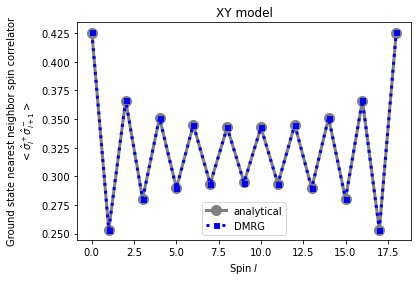

In [26]:
# plot
plt.title('XY model')
plt.xlabel('Spin $l$')
plt.ylabel('Ground state nearest neighbor spin correlator\n$< \hat{\sigma}^+_l \hat{\sigma}^-_{l+1} >$')
plt.plot([-1/(2*N+2)*( (-1)**(l+1)/np.sin(np.pi*(2*l+3)/(2*N+2)) - 1/np.sin(np.pi/(2*N+2)) ) for l in range(N-1)],
        color="gray",markersize=10,marker="o",label="analytical",linewidth=3)
plt.plot(spincorr,markersize=5,marker="s",linestyle="dotted",linewidth=3,label="DMRG",color="blue")
plt.legend()
plt.show()

$\quad$ We observe that a good agreement is obtained with 3 sweeps and $D=10$. Below, we show representative results, obtained with this code, which demonstrate how the accuracy of this particular calculation depends on both the number of sweeps and $D$.

<img src="fDMRG_XY_Egs.svg" width=500 />